In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
import os 
import seaborn as sns
import pandas as pd
from matplotlib.lines import Line2D

In [17]:
def get_ordered_subdirectories(directory):
    entries = os.listdir(directory)
    subdirs = [os.path.join(directory, entry) 
               for entry in entries if os.path.isdir(os.path.join(directory, entry))]
    subdirs.sort()
    return subdirs

base = os.path.join(os.getcwd(),"ExperimentLogs")
ordered_subdirs = get_ordered_subdirectories(base)
last_exp = ordered_subdirs[0] # Acces latest experiment run 
print(last_exp)

C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\ZZZ_largest


In [18]:
def load_all_pickles(directory:str, model: str, graphtype: str) -> list:
    """
    Iterates over all pickle files in the specified directory and loads them.
    
    :param directory: Path to the directory containing the pickle files
    :return: A list of loaded objects from the pickle files
    """
    loaded_objects = []
    final_path = os.path.join(directory, model, graphtype)
    
    # Iterate over all files in the directory
    for filename in os.listdir(final_path):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
    
    return loaded_objects
 

## Store the results of all Model/Scenario Combinations 

In [19]:
# Graphtype must match with the names specified in config.py 
gcn_perfect = load_all_pickles(last_exp, "GCN", "perfect")
gat_perfect = load_all_pickles(last_exp, "GAT", "perfect")
sage_perfect = load_all_pickles(last_exp, "SAGE", "perfect")
XG_perfect = load_all_pickles(last_exp, "XGBOOST", "perfect")

gcn_com = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant")
gat_com = load_all_pickles(last_exp, "GAT", "community_relevant")
sage_com = load_all_pickles(last_exp, "SAGE", "community_relevant")
XG_com = load_all_pickles(last_exp, "XGBOOST", "community_relevant")

gcn_com_h = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_heterophilic")
gat_com_h = load_all_pickles(last_exp, "GAT", "community_relevant_heterophilic")
sage_com_h = load_all_pickles(last_exp, "SAGE", "community_relevant_heterophilic")
XG_com_h = load_all_pickles(last_exp, "XGBOOST", "community_relevant_heterophilic")

# gcn_com_r = load_all_pickles(directory=last_exp,model="GCN",graphtype="community_relevant_random")
# gat_com_r = load_all_pickles(last_exp, "GAT", "community_relevant_random")
# sage_com_r = load_all_pickles(last_exp, "SAGE", "community_relevant_random")
# XG_com_r = load_all_pickles(last_exp, "XGBOOST", "community_relevant_random")

gcn_feat = load_all_pickles(directory=last_exp,model="GCN",graphtype="cluster_relevant")
gat_feat = load_all_pickles(last_exp, "GAT", "cluster_relevant")
sage_feat = load_all_pickles(last_exp, "SAGE", "cluster_relevant")
XG_feat = load_all_pickles(last_exp, "XGBOOST", "cluster_relevant")

gcn_feat_p = load_all_pickles(directory=last_exp,model="GCN",graphtype="non_seperated_cluster_relevant")
gat_feat_p = load_all_pickles(last_exp, "GAT", "non_seperated_cluster_relevant")
sage_feat_p = load_all_pickles(last_exp, "SAGE", "non_seperated_cluster_relevant")
XG_feat_p = load_all_pickles(last_exp, "XGBOOST", "non_seperated_cluster_relevant")

gcn_noise = load_all_pickles(directory=last_exp,model="GCN",graphtype="noise")
gat_noise = load_all_pickles(last_exp, "GAT", "noise")
sage_noise = load_all_pickles(last_exp, "SAGE", "noise")
XG_noise = load_all_pickles(last_exp, "XGBOOST", "noise")


In [20]:
package = np.array([[gcn_perfect, gcn_com, gcn_com_h, gcn_feat, gcn_feat_p, gcn_noise],  
           [gat_perfect, gat_com, gat_com_h ,gat_feat, gat_feat_p, gat_noise],  
           [sage_perfect, sage_com, sage_com_h, sage_feat, sage_feat_p, sage_noise],  
           [XG_perfect, XG_com, XG_com_h ,XG_feat, XG_feat_p, XG_noise]])

# Plot 

In [36]:
def plot_with_confidence_interval(target, color, key="loss_track", empirical_CI=True, ax=None):
    """
    Plots figure for one Scenario in specified axis.
    :param target: Results of the scenario.
    :param color: Color for scenario mapping.
    :param key: Key to extract values from target.
    :param empirical_CI: Boolean to use empirical confidence interval.
    :param ax: Axis object to plot on.
    :return: None
    """
    ys = np.array([lp[key] for lp in target])  # loss-values @ epoch
    final_epoch = np.mean([lp["final_epoch"] for lp in target])

    mean_ys = np.mean(ys, axis=0)
    std_ys = np.sqrt(np.var(ys, axis=0))

    if empirical_CI:
        ci_lower = np.percentile(ys, 2.5, axis=0)
        ci_upper = np.percentile(ys, 97.5, axis=0)
    else:
        ci_upper = mean_ys + 1.96 * std_ys
        ci_lower = mean_ys - 1.96 * std_ys

    x = np.arange(len(mean_ys))

    ax.plot(x, mean_ys, color=color)
    ax.fill_between(x, ci_lower, ci_upper, color=color, alpha=0.2)
    ax.axvline(x=final_epoch, color=color, linestyle='--')
    
    return final_epoch



### Loss Curves

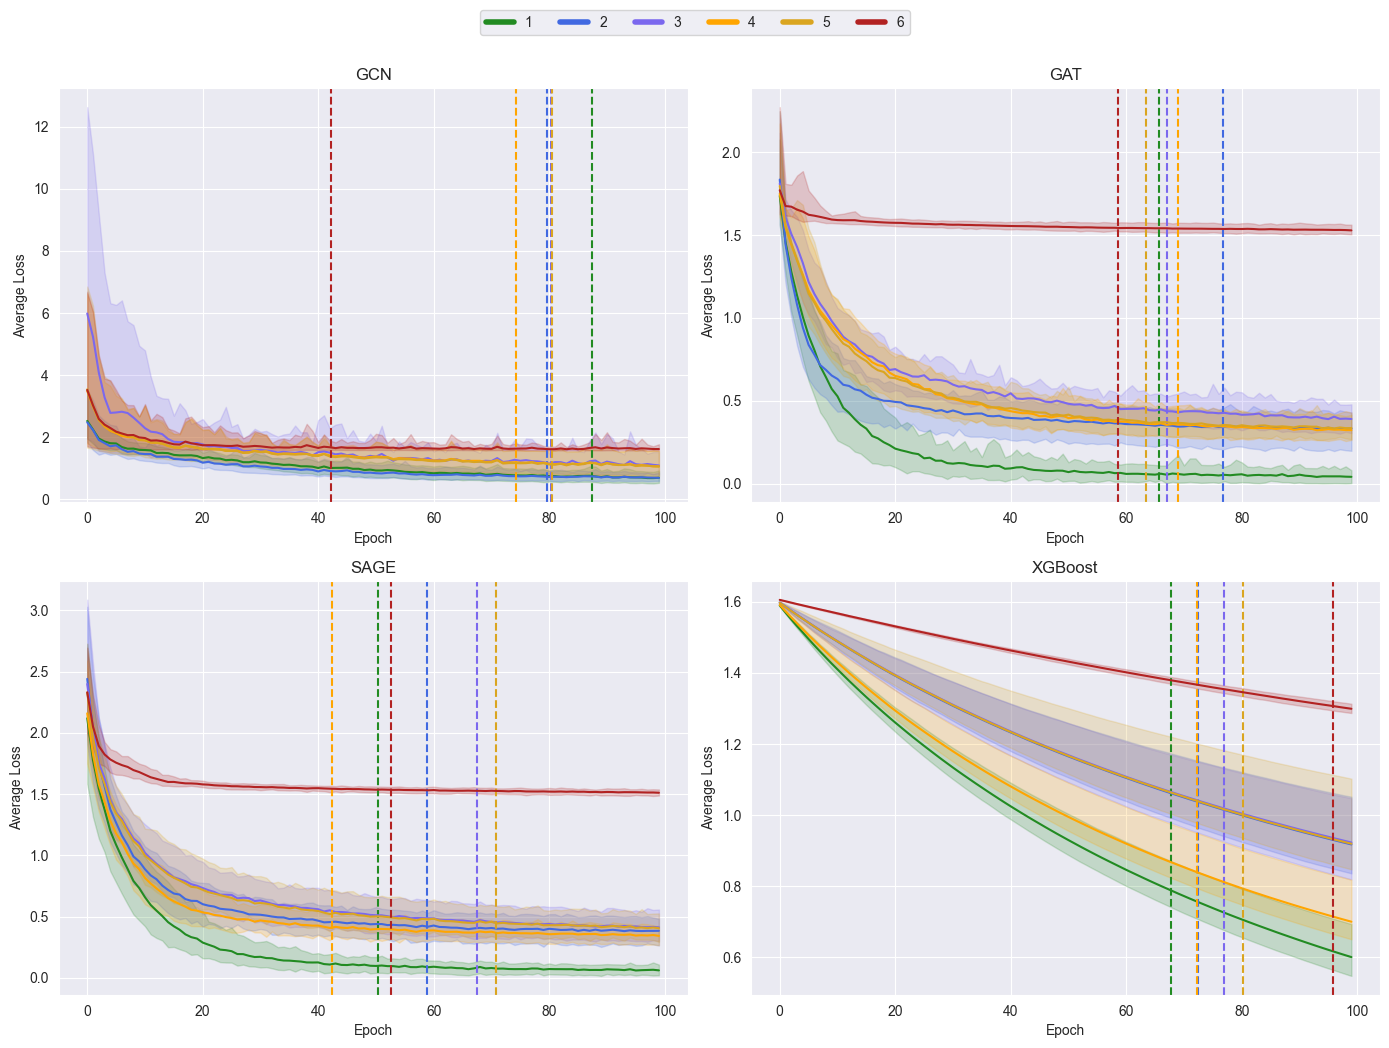

In [37]:
l_o_a = "loss_track"  
#l_o_a = "val_acc_track"

arch = ["GCN", "GAT", "SAGE", "XGBoost"]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  
axes = axes.flatten()  

early_stops = np.zeros((4, 6))

#labels = ['perfect', "c_rel", "c_rel_h", "f_rel", "f_rel_p", "noise"]
labels = np.arange(6) + 1
colors = ["forestgreen", "royalblue", "mediumslateblue", "orange", "goldenrod", "firebrick"]


for i, (model, ax) in enumerate(zip(package, axes)):
    for j, (target, label, color) in enumerate(zip(model, labels, colors)):
        early_stops[i, j] = plot_with_confidence_interval(target, color, key=l_o_a, empirical_CI=True, ax=ax)
        ax.plot([], [], color=color, label=label)  # Adding to legend

    ax.set_xlabel('Epoch')
    if l_o_a == "loss_track":
        ax.set_ylabel('Average Loss')
    else:
        ax.set_ylabel('Average Validation Accuracy')
    
    ax.set_title(f'{arch[i]}')

handles = [Line2D([0], [0], color=color, lw=4) for color in colors]
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize='medium')

plt.tight_layout()
plt.show()


In [40]:
np.round(early_stops,2)

array([[87.4 , 79.6 , 80.3 , 74.17, 80.4 , 42.17],
       [65.73, 76.73, 67.  , 68.97, 63.5 , 58.53],
       [50.43, 58.9 , 67.5 , 42.43, 70.8 , 52.67],
       [67.8 , 72.43, 76.9 , 72.27, 80.27, 95.73]])

### Test accs 

In [ ]:
def plot_acc_kde(target, color, label):
    test_accs = np.array([lp["test_accuracy"] for lp in target])
    avg_acc = np.mean(test_accs)
    sns.kdeplot(test_accs, color=color, label=label, fill=True)  # Use kdeplot for density estimation
    plt.axvline(x=avg_acc, color=color, linestyle='--')


arch = ["GCN", "GAT", "SAGE", "XGBoost"] # "val_acc_track"
for i, model in enumerate(package):  # XG

    labels = ['perfect', "c_rel", "c_rel_h", "f_rel", "f_rel_p", "noise"]  
    colors = ["forestgreen", "royalblue", "mediumslateblue", "orange", "goldenrod", "firebrick"]
    
    plt.figure()
    for target, label, color in zip(model, labels, colors):
        plot_acc_kde(target, color, label)  # Call kde plot function for each target
    
    plt.xlabel('Test Accuracy')
    plt.ylabel('Density')
    plt.title(f'Model {arch[i]}')  
    plt.legend(loc='upper right')
    plt.show()


In [23]:
mus = np.zeros((4, 6))  # models (i) x scenarios (j)
sigs = np.zeros((4, 6))  

for i, model in enumerate(package): #[[GCN,...], [GAT,...],...]
    for j, scen in enumerate(model): # [1, 2, 3, 4, 5, 6]
        accs = [acc["test_accuracy"] for acc in scen]
        
        mus[i, j] += np.round(np.mean(accs), 3)
        sigs[i, j] += np.round(np.sqrt(np.var(accs)), 3)


result = np.array([[f'{a} ({b})' for a, b in zip(row_A, row_B)] for row_A, row_B in zip(mus, sigs)])        
result = pd.DataFrame(result,
                      index=["GCN", "GAT","SAGE","XGBoost"],
                      columns=["Perfect", "com", "com_h", "feat", "feat_p", "noise"])
result


,Perfect,com,com_h,feat,feat_p,noise
GCN,0.764 (0.084),0.797 (0.031),0.587 (0.223),0.554 (0.249),0.591 (0.248),0.226 (0.041)
GAT,0.989 (0.01),0.922 (0.023),0.889 (0.043),0.916 (0.031),0.911 (0.025),0.305 (0.036)
SAGE,0.991 (0.008),0.913 (0.029),0.903 (0.033),0.934 (0.02),0.899 (0.029),0.283 (0.035)
XGBoost,0.968 (0.038),0.762 (0.075),0.753 (0.072),0.915 (0.036),0.741 (0.086),0.243 (0.036)


# Graph Characteristics 

In [24]:
def load_all_pickles_char(directory:str, graphtype: str) -> list:
    """
    Iterates over all pickle files in the specified directory and loads them.
    
    :param directory: Path to the directory containing the pickle files
    :return: A list of loaded objects from the pickle files
    """
    loaded_objects = []
    final_path = os.path.join(directory, "GraphCharacteristics", graphtype)
    
    # Iterate over all files in the directory
    for filename in os.listdir(final_path):
        if filename[0] == "o": #  output_.pkl
            file_path = os.path.join(final_path, filename)
            with open(file_path, 'rb') as file:
                loaded_objects.append(pickle.load(file))
    
    return loaded_objects
 

In [25]:
perfect = load_all_pickles_char(directory=last_exp,graphtype="perfect")
community_relevant = load_all_pickles_char(directory=last_exp,graphtype="community_relevant")
community_relevant_h = load_all_pickles_char(directory=last_exp,graphtype="community_relevant_heterophilic")
cluster_relevant = load_all_pickles_char(directory=last_exp,graphtype="cluster_relevant")
cluster_relevant_p = load_all_pickles_char(directory=last_exp,graphtype="non_seperated_cluster_relevant")
noise = load_all_pickles_char(directory=last_exp,graphtype="noise")

In [27]:
def plot_kde(target: dict, color:str, label:str, metric="h", filter=False):
    if metric == "h":
        y = np.array([lp["h_hat"] for lp in target])  # vector of values 
    if metric == "l":
        y = np.array([lp["wilks_lambda"][0] for lp in target])
        ps = np.array([True if p["wilks_lambda"][1] <= .05 else False for p in target])
    if filter:
        y = y[ps]
        print(label,": ", 30 - sum(ps))
        
    avg_y = np.mean(y)
    sns.kdeplot(y, color=color, label=label, fill=True) 
    plt.axvline(x=avg_y, color=color, linestyle='--')


In [ ]:
mtrc = "h"
fltr = False

plt.figure()
plot_kde(perfect, color='green', label='perfect', metric=mtrc, filter=fltr)
plot_kde(community_relevant, color='blue', label='community', metric=mtrc, filter=fltr)
plot_kde(community_relevant_h, color='purple', label='community_h', metric=mtrc, filter=fltr)
plot_kde(cluster_relevant, color='yellow', label='feature', metric=mtrc, filter=fltr)
plot_kde(cluster_relevant_p, color='orange', label='feature_p', metric=mtrc, filter=fltr)
plot_kde(noise, color='red', label='noise', metric=mtrc, filter=fltr)
plt.legend()
plt.show()

In [29]:
mus = np.zeros((2, 6))  
sigs = np.zeros((2, 6))  

for k, m in enumerate(["h_hat", "wilks_lambda"]):
    for i, s in enumerate([perfect, community_relevant, community_relevant_h, cluster_relevant, cluster_relevant_p, noise]): 
        y = [acc[m] for j, acc in enumerate(s)]
        accuracy = np.mean(y)
        sd_accuracy = np.var(y)
        mus[k, i] += np.round(accuracy, 3)
        sigs[k, i] += np.round(np.sqrt(sd_accuracy), 3)
    
    
    result = np.array([[f'{a} ({b})' for a, b in zip(row_A, row_B)] for row_A, row_B in zip(mus, sigs)])        
    result = pd.DataFrame(result,
                          index=["h", "L"],
                          columns=["Perfect", "com", "com_h" ,"feat", "feat_p", "noise"])

result

,Perfect,com,com_h,feat,feat_p,noise
h,0.439 (0.003),0.551 (0.02),0.0 (0.0),0.001 (0.0),0.001 (0.0),0.002 (0.001)
L,0.122 (0.141),0.289 (0.305),0.29 (0.302),0.199 (0.217),0.32 (0.33),0.51 (0.474)


In [30]:
path = r"C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\ZZZ_largest\GraphCharacteristics\perfect"
path2 = r"C:\Users\zogaj\PycharmProjects\MA\ExperimentLogs\ZZZ_largest\GraphCharacteristics2\perfect"

check = []
check2 = []

for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    with open(file_path, 'rb') as file:
        check.append(pickle.load(file))

for filename in os.listdir(path2):
    file_path = os.path.join(path2, filename)
    with open(file_path, 'rb') as file:
        check2.append(pickle.load(file))

print(check[28])
print(check2[28])

In [4]:
4 * 6 * 30

720